# The training engine

In [14]:
%%writefile engine.py

import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

from torch.utils.tensorboard import SummaryWriter


default_device = "cuda" if torch.cuda.is_available() else "cpu"

def train_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    device: torch.device = default_device,
) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.
    
    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).
    
    Args:
      model: A PyTorch model to be trained.
      dataloader: A DataLoader instance for the model to be trained on.
      loss_fn: A PyTorch loss function to minimize.
      optimizer: A PyTorch optimizer to help minimize the loss function.
      device: A target device to compute on (e.g. "cuda" or "cpu").
    
    Returns:
      A tuple of training loss and training accuracy metrics.
      In the form (train_loss, train_accuracy). For example:
    
      (0.1112, 0.8743)
    """
    # Put model in eval mode
    model.train()
    
    # Setup test loss and test accuracy values
    train_loss, train_acc = 0, 0
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # 1. Forward
        y_pred = model(X)
        
        # 2. Calculate and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        # 3. Optimizer zero grad
        optimizer.zero_grad()
        
        # 4. Loss backward
        loss.backward()
        
        # 5. Optimizer step
        optimizer.step()
        
        # Calcaualte and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)
        
    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc


def test_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    device: torch.device = default_device,
) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.
    
    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.
    
    Args:
      model: A PyTorch model to be tested.
      dataloader: A DataLoader instance for the model to be tested on.
      loss_fn: A PyTorch loss function to calculate loss on the test data.
      device: A target device to compute on (e.g. "cuda" or "cpu").
    
    Returns:
      A tuple of testing loss and testing accuracy metrics.
      In the form (test_loss, test_accuracy). For example:
    
      (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval()
        
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            
            # 1. Forward
            test_pred_logits = model(X)
            
            # 2. Caculate and accumulate loss
            loss = loss_fn (test_pred_logits, y)
            test_loss += loss.item()
            
            # Caculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuray per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module,
    epochs: int,
    writer: torch.utils.tensorboard.writer.SummaryWriter,
    device: torch.device = default_device,
) -> Dict[str, List]:
    """Trains and tests a PyTorch model.
    
    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.
    
    Calculates, prints and stores evaluation metrics throughout.
    
    Args:
      model: A PyTorch model to be trained and tested.
      train_dataloader: A DataLoader instance for the model to be trained on.
      test_dataloader: A DataLoader instance for the model to be tested on.
      optimizer: A PyTorch optimizer to help minimize the loss function.
      loss_fn: A PyTorch loss function to calculate loss on both datasets.
      epochs: An integer indicating how many epochs to train for.
      device: A target device to compute on (e.g. "cuda" or "cpu").
    
    Returns:
      A dictionary of training and testing loss as well as training and
      testing accuracy metrics. Each metric has a value in a list for 
      each epoch.
      In the form: {train_loss: [...],
                    train_acc: [...],
                    test_loss: [...],
                    test_acc: [...]} 
      For example if training for epochs=2: 
                   {train_loss: [2.0616, 1.0537],
                    train_acc: [0.3945, 0.3945],
                    test_loss: [1.2641, 1.5706],
                    test_acc: [0.3400, 0.2973]} 
    """
    
    # Create empty results dictionary
    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": [],
    }
    
    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(
                                    model=model,
                                    dataloader=train_dataloader,
                                    loss_fn=loss_fn,
                                    optimizer=optimizer,
                                    device=device
                                )
        test_loss, test_acc = test_step(
                                    model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device
                                )
        
        # Print out wha'ts happening
        print (
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )
      
        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        
        # See if there's a writer, if so, log to it
        if writer:
            # Add results to SummaryWriter
            writer.add_scalars(main_tag="Loss", 
                               tag_scalar_dict={"train_loss": train_loss,
                                                "test_loss": test_loss},
                               global_step=epoch)
            writer.add_scalars(main_tag="Accuracy", 
                               tag_scalar_dict={"train_acc": train_acc,
                                                "test_acc": test_acc}, 
                               global_step=epoch)

            # Close the writer
            writer.close()
        else:
            pass
        
    # Return the filled results at the end of the epochs
    return results


Overwriting engine.py


# Utils

In [15]:
%%writefile utils.py
import torch
import os
from typing import Dict, List, Tuple
import matplotlib.pyplot as plt
import engine

default_device = "cuda" if torch.cuda.is_available() else "cpu"


def save_model(
        model: torch.nn.Module,
        path: str,   
    ) -> None:
    """Saves a PyTorch model to a target directory.
    
    Args:
      model: A target PyTorch model to save.
      target_dir: A directory for saving the model to.
      model_name: A filename for the saved model. Should include
        either ".pth" or ".pt" as the file extension.
    
    Example usage:
      save_model(model=model_0,
                 target_dir="models",
                 model_name="05_going_modular_tingvgg_model.pth")
    """
    
    assert path.endswith(".pth") or path.endswith(".pt")

    
    abs_path = os.path.abspath(path)
    dirname = os.path.dirname(abs_path)
    os.makedirs(dirname, exist_ok=True)
    
    print(f"Saving model to: {path}")
    torch.save(obj=model.state_dict(), f=path)
    
def plot_loss_curves(results: Dict[str, List[float]]) -> None:
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    loss = results['train_loss']
    test_loss = results['test_loss']
    
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']
    
    # Figure out how many epochs
    epochs = range(len(loss))
    
    plt.figure(figsize=(15,7))
    
    # plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    
    # plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    
    plt.show()
    
def create_writer(model_name: str) -> torch.utils.tensorboard.writer.SummaryWriter:
    from datetime import datetime
    from torch.utils.tensorboard import SummaryWriter
    import os
    
    # Get timestamp of current date (all experiments on certain day live in same folder)
    timestamp = datetime.now().strftime("%Y-%m-%d") # returns current date in YYYY-MM-DD format

    log_dir = os.path.join("./runs", timestamp, model_name)
        
    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
    return SummaryWriter(log_dir=log_dir)
    
def train_and_save(
    # TODO: parameters
    model: torch.nn.Module,
    train_dataloader,
    test_dataloader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module,
    epochs: int,
    model_name: str,
    model_dir: str = "./models",
    device: torch.device = default_device
) -> Dict[str, List]:
    
    model = model.to(device)
    
    writer=create_writer(model_name)
    
    model_path = os.path.join(model_dir, model_name) + '.pt'
    
    metrics=engine.train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                loss_fn=loss_fn,
                optimizer=optimizer,
                epochs=epochs,
                writer=writer,
                device=device)
    
    
    save_model(model=model, path=model_path)
    
    plot_loss_curves(metrics)

    return metrics

def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)
    
    
def summary(model, input_size):
    import torchinfo

    return torchinfo.summary(model,
        input_size=input_size,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
    )

Overwriting utils.py


# Making custom model

In [3]:
import torch
from torch import nn

class CustomVGG(nn.Module):
    def __init__ (
        self, 
        input_shape: int, 
        hidden_units: int,
        output_shape: int,
    ) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                     out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                     out_channels=hidden_units,
                     kernel_size=3,
                     stride=1,
                     padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                        stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier=nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*56*56,
                     out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Inference

In [4]:
%%writefile inference.py

from typing import List
import torch
import torchvision
import matplotlib.pyplot as plt
import data_utils
import PIL

default_device = "cuda" if torch.cuda.is_available() else "cpu"



def predict(model: torch.nn.Module, 
                        image_path: str, 
                        class_names: List[str] = None, 
                        device: torch.device = default_device,
                        transform=None,
                        topk = 3,
           ):
    """Makes a prediction on a target image and plots the image with its prediction."""
    
    # 1. Load in image
    pil_image = PIL.Image.open(image_path)
        
    # 2. Transform with the same transformer
    if transform:
        target_image = transform(pil_image)
        
    
    # 3. Make sure the model is on the target device
    model.to(device)
    
    # 4. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)
    
        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))
        
    # 5. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 6. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)    
    
    probs, indexes = target_image_pred_probs.data[0].topk(topk,sorted=True, largest=True)
    probs = probs.tolist()
    indexes = indexes.tolist()
    
    prob = probs[0]
    pred = indexes[0]
    

    # 7. Plot the image alongside the prediction and prediction probability
    if class_names:
        title = f"Pred: {class_names[pred]} | Prob: {prob:.3f}"

        for p, i in zip(probs, indexes):
            print (f"{class_names[i]: <20} : {p:.3f}")
    else: 
        title = f"Pred: {pred} | Prob: {prob:.3f}"
        
    data_utils.plot_images([pil_image, target_image.squeeze(dim=0)], [title, title])    

Overwriting inference.py


# Predict with untrained model

## Create data loader

In [18]:
import dataset
from torchvision import transforms

train_transform=transforms.Compose([
    dataset.SquarePad(fill=255),
    transforms.Resize((224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


test_validate_transform=transforms.Compose([
    dataset.SquarePad(fill=255),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


train_dataloader, test_dataloader, validate_dataloader, names = dataset.create_dataloaders(
    train_transform=train_transform,
    test_transform=test_validate_transform,
    validate_transform=test_validate_transform,
)


## Create model

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
vgg_like_model = CustomVGG(input_shape=3,
                              hidden_units=10, 
                              output_shape=len(names)).to(device)

In [20]:
vgg_like_model

CustomVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=31360, out_features=37, bias=True)
  )
)

In [21]:
!pip install torchinfo
from torchinfo import summary

summary(vgg_like_model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
CustomVGG (CustomVGG)                    [32, 3, 224, 224]    [32, 37]             --                   True
├─Sequential (conv_block_1)              [32, 3, 224, 224]    [32, 10, 112, 112]   --                   True
│    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 10, 224, 224]   280                  True
│    └─ReLU (1)                          [32, 10, 224, 224]   [32, 10, 224, 224]   --                   --
│    └─Conv2d (2)                        [32, 10, 224, 224]   [32, 10, 224, 224]   910                  True
│    └─ReLU (3)                          [32, 10, 224, 224]   [32, 10, 224, 224]   --                   --
│    └─MaxPool2d (4)                     [32, 10, 224, 224]   [32, 10, 112, 112]   --                   --
├─Sequential (conv_block_2)              [32, 10, 112, 112]   [32, 10, 56, 56]     --                   True
│    └─Conv2d (0)   

## Making predictions

In [22]:
import importlib
importlib.reload(inference)

<module 'inference' from '/workspace/inference.py'>

In [23]:
import data_utils
import inference

imgs=data_utils.get_random_images("./data/gunpla/validate/RG01", k=3)
print (imgs)

[PosixPath('data/gunpla/validate/RG01/81GJHP36CcL._AC_SX679_.jpg'), PosixPath('data/gunpla/validate/RG01/81j8GYy9pNL._AC_SX679_.jpg'), PosixPath('data/gunpla/validate/RG01/71WW5b+mvoL._AC_SX679_.jpg')]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


RG09 ZGMF-X09A Justice Gundam : 0.029
RG01 RX-78-2 Gundam  : 0.029
RG05 ZGMF-X10A Freedom Gundam : 0.029


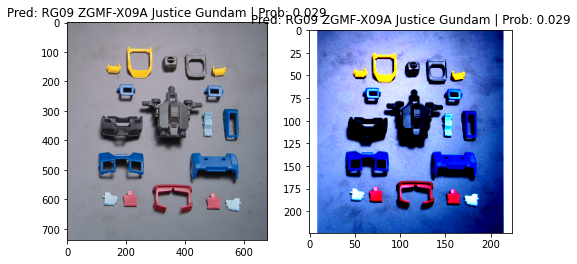

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


RG09 ZGMF-X09A Justice Gundam : 0.030
RG19 MBF-P02 Gundam Astray Red Frame : 0.029
RG01 RX-78-2 Gundam  : 0.029


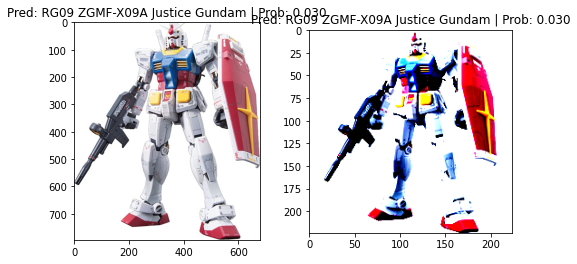

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


RG19 MBF-P02 Gundam Astray Red Frame : 0.032
RG09 ZGMF-X09A Justice Gundam : 0.032
RG33 ZGMF-X56S_α Force Impulse Gundam : 0.031


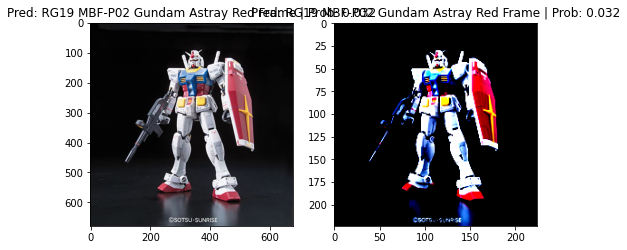

In [24]:
predict_transforms = transforms.Compose([
    data_utils.SquarePad(fill=255),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


for img in imgs:
    inference.predict(
        model=vgg_like_model, 
        image_path=img, 
        class_names=names,
        transform=predict_transforms, 
        topk=3)


# Training the model

  5%|██████████▎                                                                                                                                                                                                    | 1/20 [00:08<02:42,  8.55s/it]

Epoch: 1 | train_loss: 3.5724 | train_acc: 0.0599 | test_loss: 3.4561 | test_acc: 0.0437


 10%|████████████████████▋                                                                                                                                                                                          | 2/20 [00:16<02:29,  8.29s/it]

Epoch: 2 | train_loss: 3.3913 | train_acc: 0.0844 | test_loss: 3.0909 | test_acc: 0.1521


 15%|███████████████████████████████                                                                                                                                                                                | 3/20 [00:25<02:22,  8.35s/it]

Epoch: 3 | train_loss: 3.0277 | train_acc: 0.1847 | test_loss: 2.8135 | test_acc: 0.2250


 20%|█████████████████████████████████████████▍                                                                                                                                                                     | 4/20 [00:33<02:11,  8.25s/it]

Epoch: 4 | train_loss: 2.7168 | train_acc: 0.2871 | test_loss: 2.6955 | test_acc: 0.2573


 25%|███████████████████████████████████████████████████▊                                                                                                                                                           | 5/20 [00:41<02:05,  8.37s/it]

Epoch: 5 | train_loss: 2.3065 | train_acc: 0.3980 | test_loss: 2.4450 | test_acc: 0.3042


 30%|██████████████████████████████████████████████████████████████                                                                                                                                                 | 6/20 [00:50<01:57,  8.43s/it]

Epoch: 6 | train_loss: 1.9697 | train_acc: 0.4873 | test_loss: 2.3477 | test_acc: 0.3563


 35%|████████████████████████████████████████████████████████████████████████▍                                                                                                                                      | 7/20 [00:58<01:49,  8.44s/it]

Epoch: 7 | train_loss: 1.7690 | train_acc: 0.5453 | test_loss: 2.3734 | test_acc: 0.3771


 40%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 8/20 [01:07<01:41,  8.43s/it]

Epoch: 8 | train_loss: 1.5029 | train_acc: 0.6190 | test_loss: 2.2846 | test_acc: 0.3708


 45%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 9/20 [01:15<01:32,  8.42s/it]

Epoch: 9 | train_loss: 1.3778 | train_acc: 0.6527 | test_loss: 2.2188 | test_acc: 0.3885


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 10/20 [01:24<01:24,  8.48s/it]

Epoch: 10 | train_loss: 1.3237 | train_acc: 0.6737 | test_loss: 2.2203 | test_acc: 0.3937


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 11/20 [01:32<01:15,  8.39s/it]

Epoch: 11 | train_loss: 1.1965 | train_acc: 0.7015 | test_loss: 2.1885 | test_acc: 0.4094


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 12/20 [01:40<01:06,  8.35s/it]

Epoch: 12 | train_loss: 1.1396 | train_acc: 0.7108 | test_loss: 2.0836 | test_acc: 0.4313


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 13/20 [01:48<00:58,  8.35s/it]

Epoch: 13 | train_loss: 1.2351 | train_acc: 0.6994 | test_loss: 2.2139 | test_acc: 0.4188


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 14/20 [01:57<00:49,  8.32s/it]

Epoch: 14 | train_loss: 1.0358 | train_acc: 0.7329 | test_loss: 2.0974 | test_acc: 0.4094


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 15/20 [02:05<00:41,  8.35s/it]

Epoch: 15 | train_loss: 1.0655 | train_acc: 0.7246 | test_loss: 1.9834 | test_acc: 0.4479


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 16/20 [02:14<00:33,  8.40s/it]

Epoch: 16 | train_loss: 1.0016 | train_acc: 0.7378 | test_loss: 2.0270 | test_acc: 0.4437


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 17/20 [02:22<00:25,  8.42s/it]

Epoch: 17 | train_loss: 0.9065 | train_acc: 0.7655 | test_loss: 1.9549 | test_acc: 0.4427


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 18/20 [02:31<00:16,  8.46s/it]

Epoch: 18 | train_loss: 0.8450 | train_acc: 0.7722 | test_loss: 2.0638 | test_acc: 0.4375


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 19/20 [02:39<00:08,  8.39s/it]

Epoch: 19 | train_loss: 0.9454 | train_acc: 0.7624 | test_loss: 2.0114 | test_acc: 0.4510


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:48<00:00,  8.40s/it]

Epoch: 20 | train_loss: 0.8616 | train_acc: 0.7705 | test_loss: 2.0710 | test_acc: 0.4458


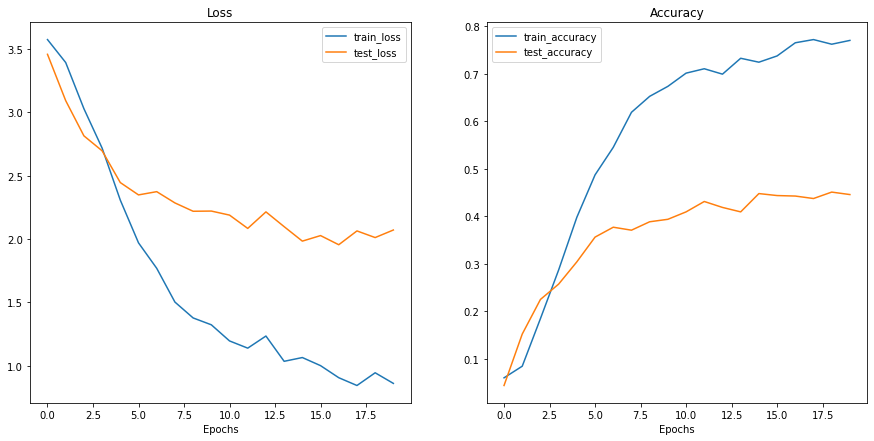

In [36]:
import engine
import utils

EPOCHS=20
LEARNING_RATE=0.001
HIDDEN_UNITS=20

device = "cuda" if torch.cuda.is_available() else "cpu"

train_transform=transforms.Compose([
    dataset.SquarePad(fill=255),
    transforms.Resize((224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


test_validate_transform=transforms.Compose([
    dataset.SquarePad(fill=255),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


train_dataloader, test_dataloader, validate_dataloader, names = dataset.create_dataloaders(
    train_transform=train_transform,
    test_transform=test_validate_transform,
    validate_transform=test_validate_transform,
)

vgg_model = CustomVGG(
        input_shape=3,
        hidden_units=HIDDEN_UNITS,
        output_shape=len(names)
    ).to(device)


optimizer = torch.optim.Adam(vgg_model.parameters(),
                                lr=LEARNING_RATE)

loss_fn = torch.nn.CrossEntropyLoss()

metrics=engine.train(model=vgg_model,
            train_dataloader=train_dataloader,
            test_dataloader=test_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            epochs=EPOCHS,
            device=device)
    
utils.plot_loss_curves(metrics)

## Evaluating the performance

In [42]:
metrics=engine.test_step(
    model=vgg_model,
    dataloader=validate_dataloader,
    loss_fn=loss_fn,
    device=device,
)

print (metrics)

(3.0564070429120744, 0.33333333333333337)


## Predict with trained model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[PosixPath('data/gunpla/validate/RG06/51SCt6MbYxL._AC_.jpg'), PosixPath('data/gunpla/validate/RG03/61n0WpnHb1L._AC_SX679_.jpg'), PosixPath('data/gunpla/validate/RG05/7100nZ3m+FL._AC_SX679_.jpg')]
RG37 GF13-017NJII God Gundam : 0.481
RG06 FX-550 Sky Grasper : 0.127
RG03 GAT-X-105 Aile Strike Gundam : 0.102


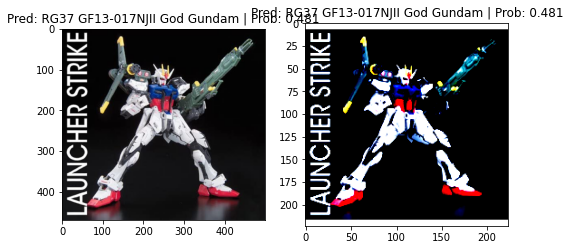

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


RG25 RX-0 Unicorn Gundam : 0.652
RG26 MS-06R-2 Johnny Ridden's Zaku II : 0.091
RG28 OZ-00MS Tallgeese EW : 0.080


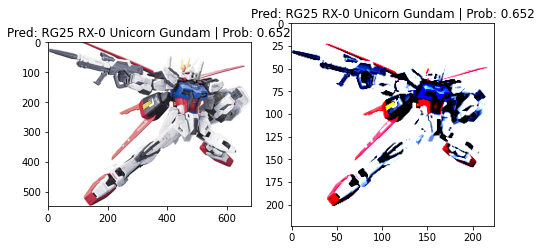

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


RG37 GF13-017NJII God Gundam : 0.381
RG36 RX-93-υ2 Hi-Nu Gundam : 0.368
RG18 GN-0000-GNR-010 OO Raiser : 0.152


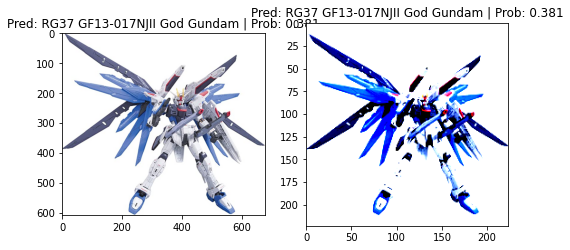

In [43]:
imgs=data_utils.get_random_images("./data/gunpla/validate", k=3)
print (imgs)

for img in imgs:
    inference.predict(
        model=vgg_model, 
        image_path=img, 
        class_names=names,
        transform=predict_transforms, 
        topk=3)